In [21]:
import keras
import pandas as pd
import os
import sys
import numpy as np
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM, Conv2D
from keras.models import Model, Sequential
from sklearn.model_selection import train_test_split

In [50]:
def word_split(mystring):
    str_split = []
    nltk_stopwords= nltk.corpus.stopwords.words('english')
    for tmp in mystring:
        tmp = tmp.lower()
        #punct_token = wordpunct_tokenize(tmp)
        tmp = re.sub('[^a-zA-Z0-9\s\?\!]+', '', tmp)
        tmp = tmp.replace('!', ' !')
        tmp = tmp.replace('?', ' ?')
        tmp = tmp.split(' ')
        '''
        punct_token = [word for word in punct_token if word not in nltk_stopwords]
        #remove string.punctuation
        punct_token = [word for word in punct_token if word not in string.punctuation]
        '''
        while True:
            if '' not in tmp:
                break
            tmp.remove('')
        while True:
            if 'the' not in tmp:
                break
            tmp.remove('the')
        while True:
            if 'and' not in tmp:
                break
            tmp.remove('and')
        while True:
            if 'of' not in tmp:
                break
            tmp.remove('of')
        '''
        while True:
            if 'is' not in tmp:
                break
            tmp.remove('is')
        while True:
            if 'are' not in tmp:
                break
            tmp.remove('are')
        '''
        str_split.append(tmp)
    return str_split

In [71]:
import nltk
nltk.download('stopwords')
import string
from nltk import wordpunct_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [85]:
GLOVE_DIR = './'
MAX_SEQUENCE_LENGTH = 45
MAX_NB_WORDS = 10000
EMBEDDING_DIM = 100
NUM_LSTM_UNITS = 512
VALIDATION_SPLIT = 0.2

In [86]:
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [87]:
all_data = pd.read_csv("train.csv")
data = all_data['Headline']
label = all_data['Label']
my_split = word_split(data)

In [88]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(my_split)
sequences = tokenizer.texts_to_sequences(my_split)
word_index = tokenizer.word_index
x = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [98]:
num_words = min(MAX_NB_WORDS, len(word_index))+1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [99]:
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [100]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
cnn = Sequential()
xx = Conv1D(NUM_LSTM_UNITS, 4, activation='relu')(embedded_sequences)
xx = MaxPooling1D(2)(xx)
xx = Dropout(0.2)(xx)
xx = Conv1D(NUM_LSTM_UNITS, 4, activation='relu')(xx)
xx = MaxPooling1D(2)(xx)
xx = Dropout(0.2)(xx)
l1 = LSTM(NUM_LSTM_UNITS, input_shape=(MAX_SEQUENCE_LENGTH, NUM_LSTM_UNITS), return_sequences=True)
l2 = LSTM(NUM_LSTM_UNITS, return_sequences=False)
xx = l1(xx)
xx = l2(xx)
predictions = Dense(units=1, activation='linear')(xx)
model = Model(inputs=sequence_input, outputs=predictions)

In [101]:
model.compile(loss=keras.losses.MeanSquaredError(),
              optimizer=keras.optimizers.SGD())
model.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 45)]              0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 45, 100)           1000100   
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 42, 512)           205312    
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 21, 512)           0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 21, 512)           0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 18, 512)           1049088   
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 9, 512)          

In [102]:
x_train, x_test, y_train, y_test = train_test_split(x, label, test_size=0.1)

In [103]:
history = model.fit(x_train, y_train ,batch_size=32 ,epochs=40,validation_data=(x_test, y_test))

Epoch 1/40
58/58 [==============================] - 12s 202ms/step - loss: 1.1168 - val_loss: 0.5878
Epoch 2/40
58/58 [==============================] - 11s 195ms/step - loss: 0.5873 - val_loss: 0.5272
Epoch 3/40
58/58 [==============================] - 11s 198ms/step - loss: 0.5316 - val_loss: 0.4900
Epoch 4/40
58/58 [==============================] - 12s 210ms/step - loss: 0.5146 - val_loss: 0.4645
Epoch 5/40
58/58 [==============================] - 12s 207ms/step - loss: 0.5074 - val_loss: 0.4455
Epoch 6/40
58/58 [==============================] - 11s 197ms/step - loss: 0.4837 - val_loss: 0.4497
Epoch 7/40
58/58 [==============================] - 11s 196ms/step - loss: 0.4730 - val_loss: 0.5096
Epoch 8/40
58/58 [==============================] - 12s 199ms/step - loss: 0.4643 - val_loss: 0.4183
Epoch 9/40
58/58 [==============================] - 12s 201ms/step - loss: 0.4637 - val_loss: 0.5261
Epoch 10/40
58/58 [==============================] - 12s 201ms/step - loss: 0.4558 - val_lo

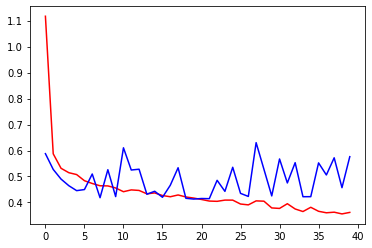

In [104]:
import matplotlib.pyplot as plt
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss,'r', val_loss, 'b')

In [112]:
test_data = pd.read_csv("test.csv")
data = test_data['Headline']
label = test_data['Label']
test_split = word_split(data)
sequences = tokenizer.texts_to_sequences(test_split)
x = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
y_pre = model.predict(x)
print(y_pre[0])
b = np.arange(1, y_pre.shape[0]+1).reshape(y_pre.shape[0], 1)
y_pre = np.append(b, y_pre, axis=1)

[2.106281]


In [106]:
import csv
with open('output.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['ID','Label'])
    writer.writerows(y_pre)

In [107]:
model.save('./mymodel_0.447/')

INFO:tensorflow:Assets written to: ./mymodel_0.447/assets


In [113]:
mm = keras.models.load_model('./mymodel_0.447/')

In [114]:
test_data = pd.read_csv("test.csv")
data = test_data['Headline']
label = test_data['Label']
test_split = word_split(data)
sequences = tokenizer.texts_to_sequences(test_split)
x = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
y_pre = mm.predict(x)
print(y_pre[0])
b = np.arange(1, y_pre.shape[0]+1).reshape(y_pre.shape[0], 1)
y_pre = np.append(b, y_pre, axis=1)

[2.106281]


In [110]:
mm.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 50, 100)           1000100   
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 47, 256)           102656    
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 23, 256)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 23, 256)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 20, 256)           262400    
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 10, 256)          